In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from itertools import chain
import string

In [2]:
# load datasets
species = pd.read_csv('species_info.csv')
species.head()

,category,scientific_name,common_names,conservation_status
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,NaN
1,Mammal,Bos bison,"American Bison, Bison",NaN
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",NaN
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",NaN
4,Mammal,Cervus elaphus,Wapiti Or Elk,NaN


In [3]:
observations = pd.read_csv('observations.csv')
observations.head()

,scientific_name,park_name,observations
0,Vicia benghalensis,Great Smoky Mountains National Park,68
1,Neovison vison,Great Smoky Mountains National Park,77
2,Prunus subcordata,Yosemite National Park,138
3,Abutilon theophrasti,Bryce National Park,84
4,Githopsis specularioides,Great Smoky Mountains National Park,85


In [4]:
# looking at data
print(f'Number of species: {species.category.nunique()}',
      f'\nTypes of species: {species.category.unique()}\n',
      f'\n{species.groupby("category").size()}\n',
      f'\n{species.groupby("conservation_status").size()}\n',
      f'\nNational parks: {observations.park_name.unique()}\n',
      f'\n{observations.observations.describe()}\n',
      f'\nNaN values: {species.isna().sum()}\n',
      f'\nNaN values: {observations.isna().sum()}\n')

Number of species: 7 
Types of species: ['Mammal' 'Bird' 'Reptile' 'Amphibian' 'Fish' 'Vascular Plant'
 'Nonvascular Plant']
 
category
Amphibian              80
Bird                  521
Fish                  127
Mammal                214
Nonvascular Plant     333
Reptile                79
Vascular Plant       4470
dtype: int64
 
conservation_status
Endangered             16
In Recovery             4
Species of Concern    161
Threatened             10
dtype: int64
 
National parks: ['Great Smoky Mountains National Park' 'Yosemite National Park'
 'Bryce National Park' 'Yellowstone National Park']
 
count    23296.000000
mean       142.287904
std         69.890532
min          9.000000
25%         86.000000
50%        124.000000
75%        195.000000
max        321.000000
Name: observations, dtype: float64
 
NaN values: category                  0
scientific_name           0
common_names              0
conservation_status    5633
dtype: int64
 
NaN values: scientific_name    0
park_name

In [9]:
# fill NaN values in conservation status to 'No Interverntion'
species.fillna('No Intervention', inplace=True)
species.groupby('conservation_status').size()

conservation_status
Endangered              16
In Recovery              4
No Intervention       5633
Species of Concern     161
Threatened              10
dtype: int64

### Analysis ###

Distribution of conservation status

In [35]:
conservationDistribution = species[species.conservation_status != "No Intervention"]\
    .groupby(['conservation_status', 'category'])['scientific_name'].count().unstack()
conservationDistribution

category,Amphibian,Bird,Fish,Mammal,Nonvascular Plant,Reptile,Vascular Plant
conservation_status,,,,,,,
Endangered,1.0,4.0,3.0,7.0,NaN,NaN,1.0
In Recovery,NaN,3.0,NaN,1.0,NaN,NaN,NaN
Species of Concern,4.0,72.0,4.0,28.0,5.0,5.0,43.0
Threatened,2.0,NaN,4.0,2.0,NaN,NaN,2.0


[Text(0, 0, 'Endangered'),
 Text(1, 0, 'In Recovery'),
 Text(2, 0, 'Species of Concern'),
 Text(3, 0, 'Threatened')]

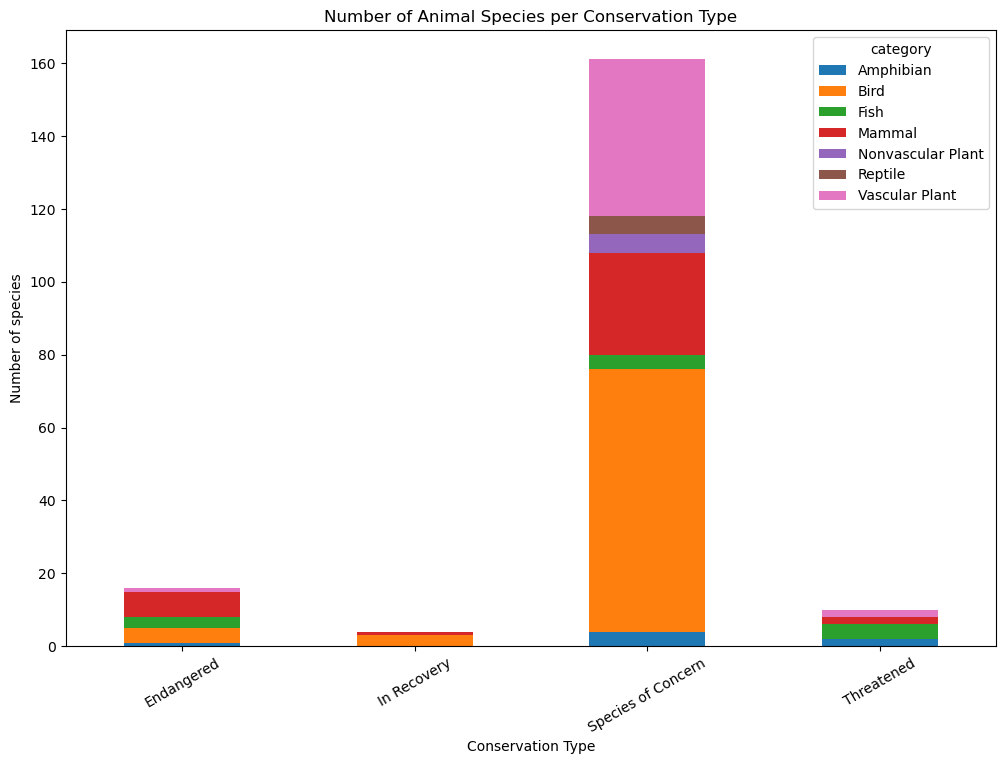

In [40]:
f, ax = plt.subplots(figsize=(12, 8))
conservationDistribution.plot(kind='bar', stacked=True, ax=ax)
ax.set_xlabel('Conservation Type')
ax.set_ylabel('Number of species')
ax.set_title('Number of Animal Species per Conservation Type')
ax.set_xticklabels(['Endangered', 'In Recovery', 'Species of Concern', 'Threatened'], rotation=30)

Endangerment likelihood of different species

In [42]:
# create column defining protected species
species['is_protected'] = species.conservation_status != 'No Intervention'

In [59]:
protection_count = species.groupby(['is_protected', 'category'])['scientific_name']\
    .nunique().reset_index().pivot(index=['category'], \
                                   columns=['is_protected'], values=['scientific_name'])\
                                    .reset_index()

protection_count.columns = ['Category', 'Not Protected', 'Protected']

protection_count

,Category,Not Protected,Protected
0,Amphibian,72,7
1,Bird,413,75
2,Fish,115,11
3,Mammal,146,30
4,Nonvascular Plant,328,5
5,Reptile,73,5
6,Vascular Plant,4216,46


In [61]:
# percentage of protection per species
protection_count['Protection Percentage'] = \
(protection_count.Protected / (protection_count.Protected + protection_count['Not Protected'])) * 100

protection_count

,Category,Not Protected,Protected,Protection Percentage
0,Amphibian,72,7,8.860759
1,Bird,413,75,15.368852
2,Fish,115,11,8.730159
3,Mammal,146,30,17.045455
4,Nonvascular Plant,328,5,1.501502
5,Reptile,73,5,6.410256
6,Vascular Plant,4216,46,1.079305


#### Statistical significance between species and conservation status ####

In [66]:
# chi2 test between mammals and birds
contingency1 = [[30, 146],
              [75, 413]]
chi_mamm_bird = chi2_contingency(contingency1)
chi_mamm_bird

Chi2ContingencyResult(statistic=0.1617014831654557, pvalue=0.6875948096661336, dof=1, expected_freq=array([[ 27.8313253, 148.1686747],
       [ 77.1686747, 410.8313253]]))

In [68]:
# chi2 test between mammals and reptiles
contingency2 = [[30, 146],
              [5, 73]]
chi_mamm_rept = chi2_contingency(contingency2)
chi_mamm_rept

Chi2ContingencyResult(statistic=4.289183096203645, pvalue=0.03835559022969898, dof=1, expected_freq=array([[ 24.2519685, 151.7480315],
       [ 10.7480315,  67.2519685]]))

Mammals need a significantly higher protection rate than reptiles, however, there was no significant difference between mammals and birds regarding protection rates.

#### Species in Parks ####

In [70]:
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

common_Names = species[species.category == "Mammal"]\
    .common_names\
    .apply(remove_punctuations)\
    .str.split().tolist()

common_Names[:6]

[['Gappers', 'RedBacked', 'Vole'],
 ['American', 'Bison', 'Bison'],
 ['Aurochs',
  'Aurochs',
  'Domestic',
  'Cattle',
  'Feral',
  'Domesticated',
  'Cattle'],
 ['Domestic', 'Sheep', 'Mouflon', 'Red', 'Sheep', 'Sheep', 'Feral'],
 ['Wapiti', 'Or', 'Elk'],
 ['WhiteTailed', 'Deer']]

In [71]:
cleanRows = []

for item in common_Names:
    item = list(dict.fromkeys(item))
    cleanRows.append(item)
    
cleanRows[:6]

[['Gappers', 'RedBacked', 'Vole'],
 ['American', 'Bison'],
 ['Aurochs', 'Domestic', 'Cattle', 'Feral', 'Domesticated'],
 ['Domestic', 'Sheep', 'Mouflon', 'Red', 'Feral'],
 ['Wapiti', 'Or', 'Elk'],
 ['WhiteTailed', 'Deer']]

In [72]:
res = list(chain.from_iterable(i if isinstance(i, list) else [i] for i in cleanRows))
res[:6]

['Gappers', 'RedBacked', 'Vole', 'American', 'Bison', 'Aurochs']

In [73]:
# count number of occurences for each word = times spotted at a park
words_counted = []

for i in res:
    x = res.count(i)
    words_counted.append((i,x))

pd.DataFrame(set(words_counted), columns =['Word', 'Count'])\
    .sort_values("Count", ascending = False).head(10)

,Word,Count
175,Bat,23
90,Shrew,18
169,Myotis,17
114,Mouse,16
29,Chipmunk,13
65,Squirrel,12
107,American,12
82,Eastern,11
31,Vole,11
14,Mountain,10


In [75]:
# figuring out which bat species is spotted the most
species['is_bat'] = species.common_names.str.contains(r"\bBat\b", regex = True)

species[species.is_bat]

,category,scientific_name,common_names,conservation_status,is_protected,is_bat
28,Mammal,Corynorhinus rafinesquii,Rafinesque's Big-Eared Bat,No Intervention,False,True
29,Mammal,Eptesicus fuscus,Big Brown Bat,Species of Concern,True,True
30,Mammal,Lasionycteris noctivagans,Silver-Haired Bat,Species of Concern,True,True
31,Mammal,Lasiurus borealis,"Eastern Red Bat, Red Bat",No Intervention,False,True
32,Mammal,Lasiurus cinereus,Hoary Bat,No Intervention,False,True
36,Mammal,Myotis leibii,"Eastern Small-Footed Bat, Eastern Small-Footed...",Species of Concern,True,True
37,Mammal,Myotis lucifugus,"Little Brown Bat, Little Brown Myotis",Species of Concern,True,True
38,Mammal,Myotis septentrionalis,"Northern Long-Eared Bat, Northern Myotis",Threatened,True,True
39,Mammal,Myotis sodalis,"Indiana Bat, Indiana Or Social Myotis",Endangered,True,True
40,Mammal,Nycticeius humeralis,Evening Bat,No Intervention,False,True


In [76]:
# merge observation df with species df where there are bat species
bat_observations = observations.merge(species[species.is_bat])
bat_observations

,scientific_name,park_name,observations,category,common_names,conservation_status,is_protected,is_bat
0,Lasiurus blossevillii,Bryce National Park,113,Mammal,Western Red Bat,Species of Concern,True,True
1,Lasiurus blossevillii,Great Smoky Mountains National Park,70,Mammal,Western Red Bat,Species of Concern,True,True
2,Lasiurus blossevillii,Yosemite National Park,123,Mammal,Western Red Bat,Species of Concern,True,True
3,Lasiurus blossevillii,Yellowstone National Park,221,Mammal,Western Red Bat,Species of Concern,True,True
4,Corynorhinus rafinesquii,Yosemite National Park,188,Mammal,Rafinesque's Big-Eared Bat,No Intervention,False,True
...,...,...,...,...,...,...,...,...
139,Myotis sodalis,Yellowstone National Park,68,Mammal,"Indiana Bat, Indiana Or Social Myotis",Endangered,True,True
140,Myotis leibii,Yosemite National Park,132,Mammal,"Eastern Small-Footed Bat, Eastern Small-Footed...",Species of Concern,True,True
141,Myotis leibii,Bryce National Park,84,Mammal,"Eastern Small-Footed Bat, Eastern Small-Footed...",Species of Concern,True,True
142,Myotis leibii,Great Smoky Mountains National Park,49,Mammal,"Eastern Small-Footed Bat, Eastern Small-Footed...",Species of Concern,True,True


In [77]:
bat_observations.groupby('park_name').observations.sum().reset_index()

,park_name,observations
0,Bryce National Park,3433
1,Great Smoky Mountains National Park,2411
2,Yellowstone National Park,8362
3,Yosemite National Park,4786
